# Customization of the MNIST Dataset

MNIST, a dataset of handwritten numeric letters (0-9), is a basic machine learning dataset for testing a hypothesis.
We are going to show one of the deep learning life cycle problems, "sequential model selection".
To show this, MNIST dataset should be splitted satisfying the followings.

1. Pre-trained Data
2. Testing Data
3. Sequentially Updating Data

## Splitting
We are going to split training dataset of MNIST into pre-trained data and initial testing data with 9:1 ratio.
The testing dataset of MNIST will be splitted into a few timesteps that will arrive sequentially on our multi-model classifier. 
Then, we are going to select the best model among those pre-trained model based on the testing accuracy. 
After that, the new arrivals will be labeled and be used to update existing models.
The models' accuracy are also updated according to updating models.
For more accurate testing, updating the testing dataset should be supported.


In [17]:
import os
import struct
import torch
from array import array
from os import path
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

plt.ion()

In [30]:
MNIST_PATH = './mnist_raw'
files = ['train-images-idx3-ubyte', 'train-labels-idx1-ubyte','t10k-labels-idx1-ubyte', 't10k-images-idx3-ubyte']

def read_mnist(dataset = "training", path = "."):
    if dataset == "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    elif dataset == 0:
        fname_img = os.path.join(path, 'emnist-letters-test-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'emnist-letters-test-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'", dataset)

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array("B", fimg.read())
    fimg.close()

    return img, lbl, size, rows, cols

'''
Outputs
img: image array
lbl: label array
rows: height
cols: width
size: # of data
'''

'\nOutputs\nimg: image array\nlbl: label array\nrows: height\ncols: width\nsize: # of data\n'

In [34]:
def show(images, labels):
    plt.imshow(images, cmap='gray')
    print("label: {}".format(labels))

In [40]:
class MNIST_Dataset(Dataset):
    def __init__(self, filepath, transform=None):
        img, lbl, size, row, col = read_mnist("training", filepath)
        self.training_imgs = np.array(img).reshape([size,row,col])
        self.training_labels = np.array(lbl).reshape([size])
        
        img, lbl, size, row, col = read_mnist("testing", filepath)
        self.testing_imgs = np.array(img).reshape([size,row,col])
        self.testing_labels = np.array(lbl).reshape([size])

        self.filepath = filepath
        self.transform = transform
        
    def __len__(self):
        return len(self.training_imgs)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = self.training_imgs[idx]
        label = self.training_labels[idx]
        sample = {'image': image, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
        return sample
        

label: 5


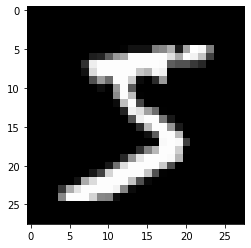

In [41]:
mnist_dataset = MNIST_Dataset(filepath = MNIST_PATH)

sample = mnist_dataset[0]
show(sample['image'], sample['label'])

0 torch.Size([1, 28, 28]) torch.Size([1])


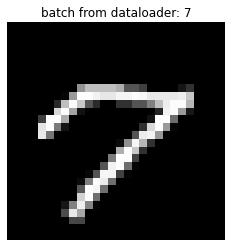

In [51]:
dataloader = DataLoader(mnist_dataset, batch_size=1, shuffle=True, num_workers=4)

def show_mnist_batch(sample_batched):
    images_batch, labels_batch = sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('batch from dataloader: {}'.format(labels_batch[0]))

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['label'].size())

    if i_batch == 0:
        plt.figure()
        show_mnist_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

label: 5


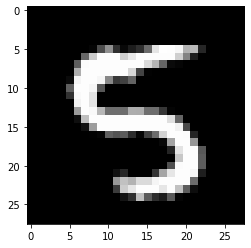

In [55]:
dataset_pre_trained = torch.utils.data.Subset(mnist_dataset, range(54000))
len(dataset_pre_trained)
dataset_testing = torch.utils.data.Subset(mnist_dataset, range(54000, 60000))
len(dataset_testing)
show(dataset_testing[0]['image'], dataset_testing[0]['label'])

## Reflecting Non-stationary of Xt (TODO)

In [64]:
try:
    os.listdir('./logs/')
except FileNotFoundError:
    #mkdir
    os.mkdir('./logs/')

In [65]:
os.listdir('./logs/')

[]

In [67]:
repr(dataset_pre_trained)

'<torch.utils.data.dataset.Subset object at 0x7f7652fa3eb0>'